# 01 - Variables are Memory References

We can find the memory address using `id()` which returns a base-10 number and can be converted to hex using `id(hex())`

If we first assign a variable to an integer, that variable looks points to the memory address (reference) which points to the integer. 

If we assign a second variable to the first variable, the second variable points to the reference of the first variable, not the integer. 

So, the integer has two references to it (count=2). We can safely delete/reassign the first variable away and then, count=1. Once the count drops to 0, that object is thrown away and that space (memory address) can be used anywhere else.

# 02 Reference Counting


We can get reference count with getrefcount via `sys.getrefcount(my_var)`. One nuance of this is that passing `my_var` to `getrefcount()` actually creates another reference to `my_var`, because variables are always passed by reference in Python. 

In [7]:
import sys
my_var = [1,2,3]
sys.getrefcount(my_var)

2

We can get round this extra reference using a method from the C library: `ctypes.c_long.from_address(address).value`, but we need to pass the memory address (reference) instead.

In [8]:
import ctypes

def ref_count(address: int):
    return ctypes.c_long.from_address(address).value

ref_count(id(my_var))

1

# 03 - Garbage Collection

Below is `my_var` which points to an object with an instance variable `var_1` (the name of the variable passed into a class which is turned into an attributed; in `self.age = age`, `age` is the instance variable) which points to another object with another instance variable.

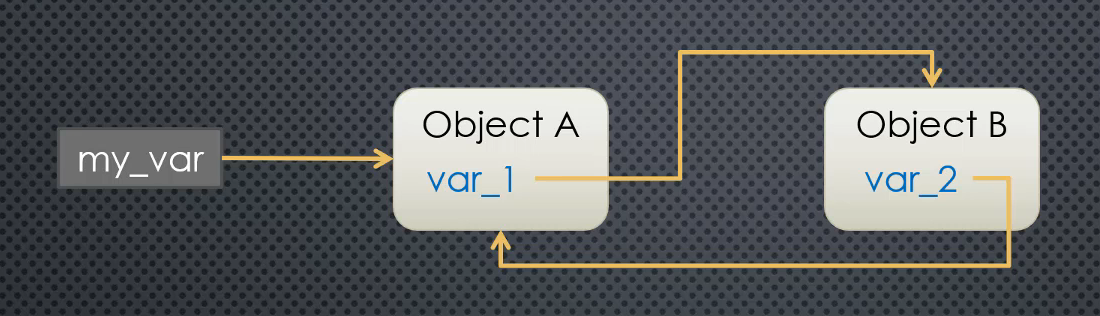

Now, in a scenario where `var_2` does not point to `Object A`, setting `my_var = None` would remove reference to Object A, therefore Object A has no references **to** it. So with its ref count = 0, it disappears. Therefore, Object B has nothing pointing to it, so it must disappear. And all that memory can be used elsewhere. 

Now if instead we have `var_2` pointing to `Object A` (as in above image), then, deleting `my_var` does not produce that chain reaction because Objects A and B are self-referencing each other. This is known as **Circular References**. 

Since the ref_count is non-zero for both, we cannot get rid of them via Python Memory Manager, and we have a **memory leak**.

To solve this, we need a **Garbage Collector** which can be controlled via the module **gc**. It runs periodically, but we can also call it manually. It's used to clean up circular references.


Let's see what this looks like in code:

In [9]:
import ctypes
import gc

def ref_count(address):
    return ctypes.c_long.from_address(address).value

We create a function that will search the objects in the GC for a specified id and tell us if the object was found or not:

In [10]:
def object_by_id(object_id):
    for obj in gc.get_objects():
        if id(obj) == object_id:
            return "Object exists"
    return "Not found"

In [11]:
class A:
    def __init__(self):
        self.b = B(self)
        print('A: self: {0}, b:{1}'.format(hex(id(self)), hex(id(self.b))))

Let's break this down:

The`self` in the `__init__` constructor refers to an **instance of A**. `B(self)` is an **instance of B**. 

So, the 1st term in the print statement is the **instance of A** and the 2nd is **instance of B**.

In [12]:
class B:
    def __init__(self, a):
        self.a = a
        print('B: self: {0}, a: {1}'.format(hex(id(self)), hex(id(self.a))))

Let's break this down:

The`self` in the `__init__` constructor in `class B` now refers to **instance of B**. 

What is `a`? From class A's calling of `B(self)`, `a` is `self` and `self` is an **instance of A**.

So, the 1st term in the print statement is the **instance of B** and the 2nd is **instance of A**.

Comparing the two markdowns above, we expect that the 1st printed term in the 1st markdown is equal to the 2nd printed term in the 2nd markdown (both being **instance of A**

In [13]:
gc.disable() 

We turn off the GC so we can see how reference counts are affected when the GC does not run and when it does (by running it manually).

In [14]:
my_var = A()

B: self: 0x7f55ff2d0070, a: 0x7f55ff2d2920
A: self: 0x7f55ff2d2920, b:0x7f55ff2d0070


Sure enough, we're correct.

From the above line, we can easily see that `my_var` is an instance of A().

In [24]:
print('a: \t{0}'.format(hex(id(my_var))))
print('a.b: \t{0}   <- This is my_var.b; my_var is an instance of A and b = B(self) and thus, b is an instance of B.'.format(hex(id(my_var.b)))) 
print('a.b.a: \t{0}   <- b is an instance of B, and b has an attribute called a which is equal to a which is equal to A\'s self (instance of A).'.format(hex(id(my_var.b.a))))

a: 	0x7f55ff2d2920
a.b: 	0x7f55ff2d0070   <- This is my_var.b; my_var is an instance of A and b = B(self) and thus, b is an instance of B.
a.b.a: 	0x7f55ff2d2920   <- b is an instance of B, and b has an attribute called a which is equal to a which is equal to A's self (instance of A).


# 04 - Dynamic vs Static Typing

In statically typed languages, we have the following arrangement:

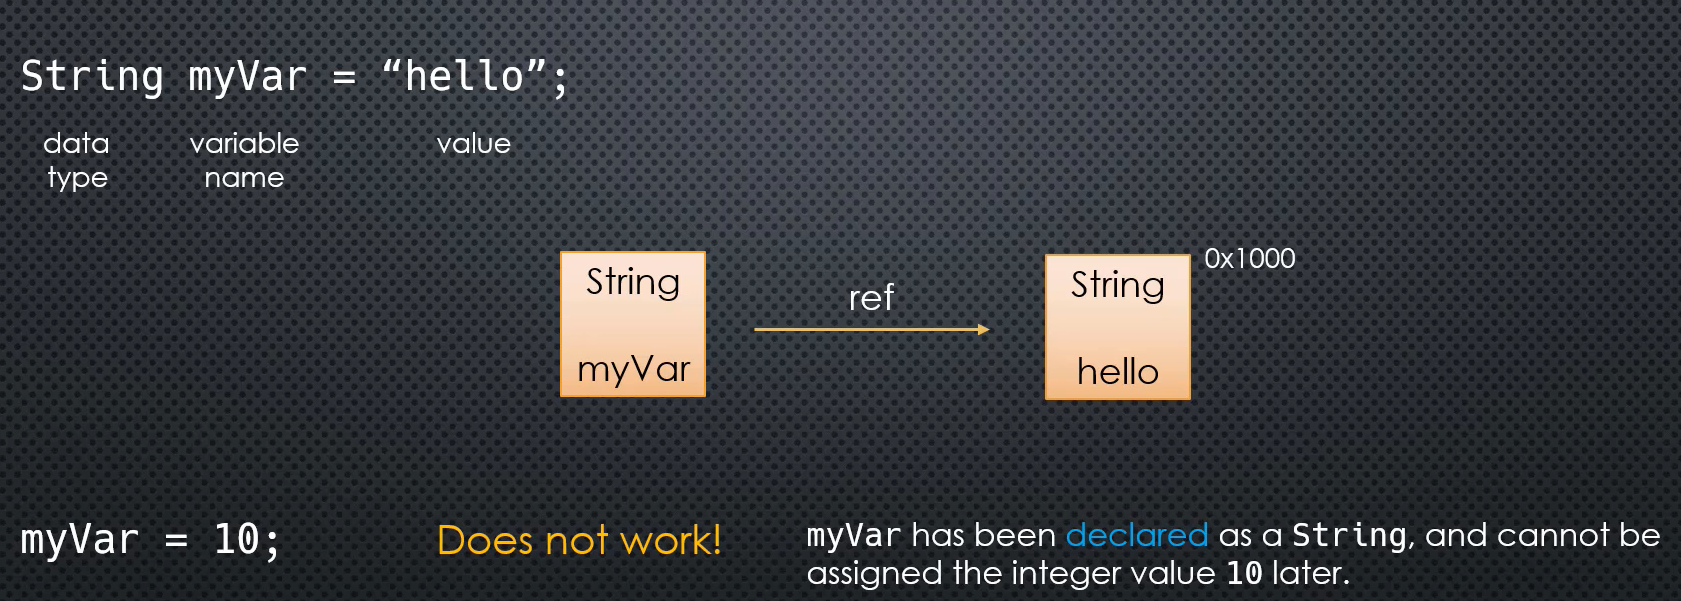

They key detail is that **myVar has been declared as a string**

In Python, my_var is just a reference, nothing more, that points to an object that *happens to be* a string. 

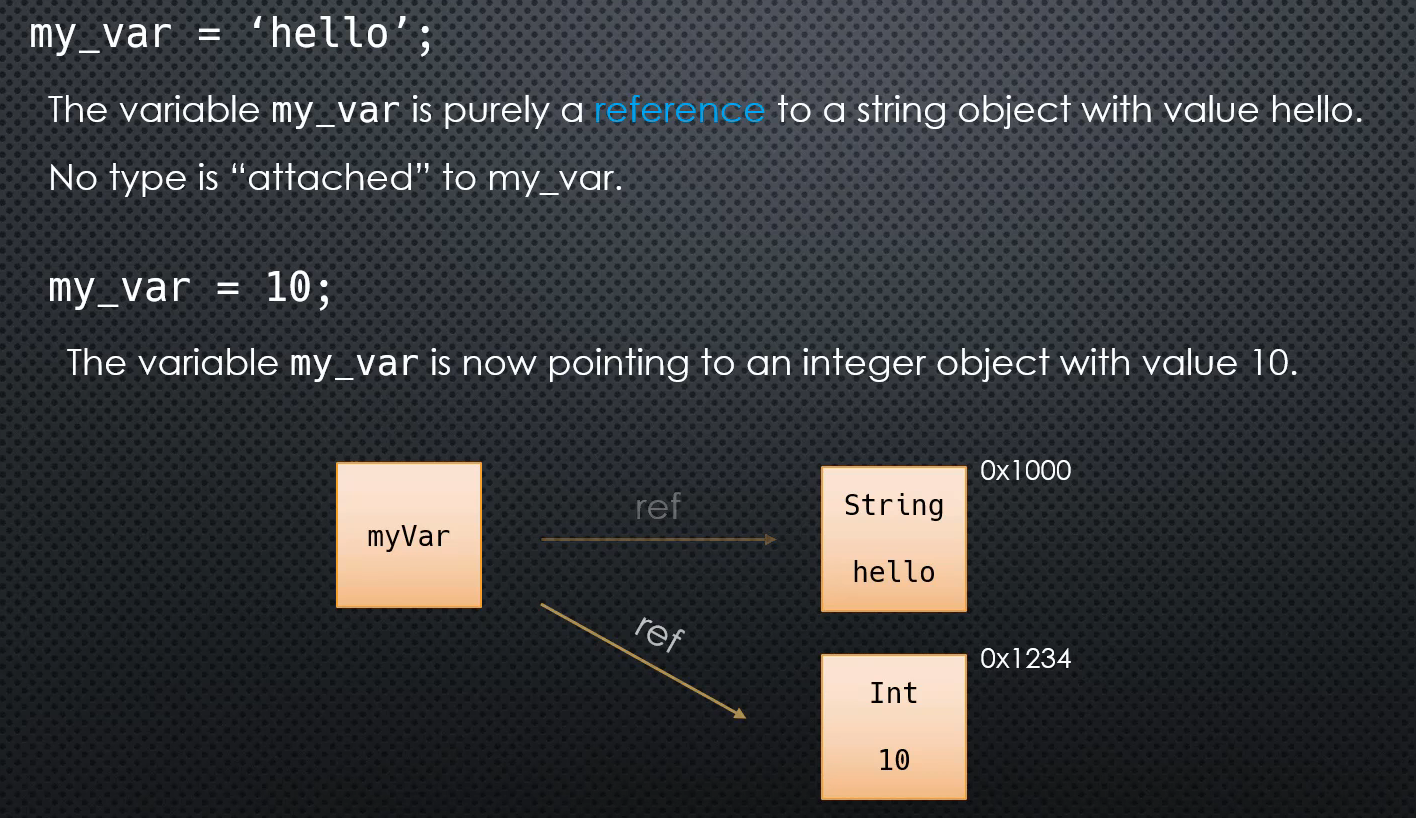

No type is attached to my_var.

All we do when we reassign `my_var` is to make it point to a **brand new**, different object. Remember **`my_var` in python has no type at all**. All that's changed is the type of object that `my_var` is pointing to.

# 05 - Variable Re-Assignment

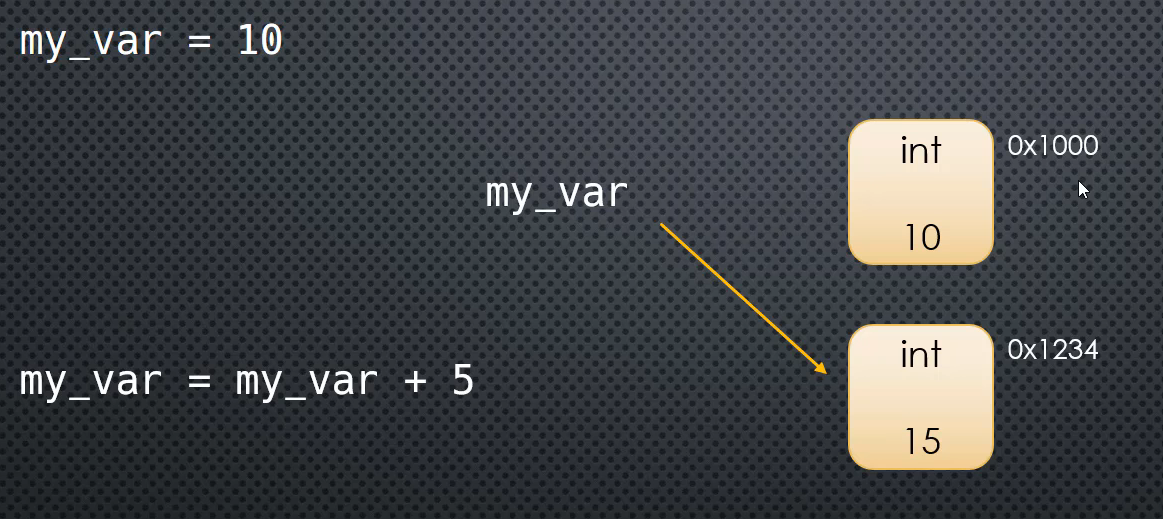

**the value inside the <u>int</u> objects can *never* be changed. We always reassign a variable to a new memory reference with that newly calculated int value.**
Therefore, integers are immutable.

# 06 - Object Mutability

Certain Python built-in object types (aka data types) are **mutable**.

That is, the internal contents (state) of the object in memory can be modified.

Immutable Examples are: numbers (floats, int, booleans), strings, tuples, frozen sets, user-defined classes (this can be forced to be immutable)

Mutable Examples are: lists, sets, dictionaries, user-defined classes (can be made to be mutable). 

Consider:

In [35]:
a = [1, 2]
b = [3, 4]

In [36]:
t = (a, b)
print(t)

([1, 2], [3, 4])


In [37]:
a.append(3)
b.append(5)

In [38]:
t

([1, 2, 3], [3, 4, 5])

The tuple is immutable, therefore the memory addresses of the 1st and 2nd slot in the tuple are fixed forever; we can't even add or remove slots to the tuple. Therefore, [1, 2] and [1, 2, 3] have the same memory address. However, since lists are mutable, we were able to **change the state** of the object (memory address) referenced by [1, 2] to a different state.

In [46]:
c = 7
d = 8

t2 = (c,d)
t2

(7, 8)

In [47]:
c = 9
d = 10
t2

(7, 8)

As expected, t2 did not change because the integers are immutable.

Now as we said before, lists are mutable, so the memory id of a list doesn't change when we add values via `list.append(some_value)`. 

But there are other ways that we can append a value which *does* change create a new memory id

In [48]:
my_list_1 = [1, 2, 3]
id(my_list_1)

140007015795584

In [49]:
my_list_1 = my_list_1 + [4]
id(my_list_1)

140006667947968

This is because, on the RHS, `my_list_1` has a memory id and `[4]` has a memory id; the result of concatenation points to a *completely different/new* memory id 

# 07 - Function Arguments and Mutability

Consider a function that receives a *string* argument, and changes the argument in some way:

In [50]:
def process(s):
    print('initial s # = {0}'.format(hex(id(s))))
    s = s + ' world'
    print('s after change # = {0}'.format(hex(id(s))))

In [51]:
my_var = 'hello'
print('my_var # = {0}'.format(hex(id(my_var))))

my_var # = 0x7f55ffaae330


In [53]:
process(my_var)
print('my_var # = {0}'.format(hex(id(my_var))))

initial s # = 0x7f55ffaae330
s after change # = 0x7f55d790fbb0
my_var # = 0x7f55ffaae330


Why is this? Because the change made in the function creates a new reference for `s` to point to, but that `s` is limited to the `process()` scope.

So, calling my_var in the module scope, it will point to the original reference. So, functions are unable to change the value of an immutable object.

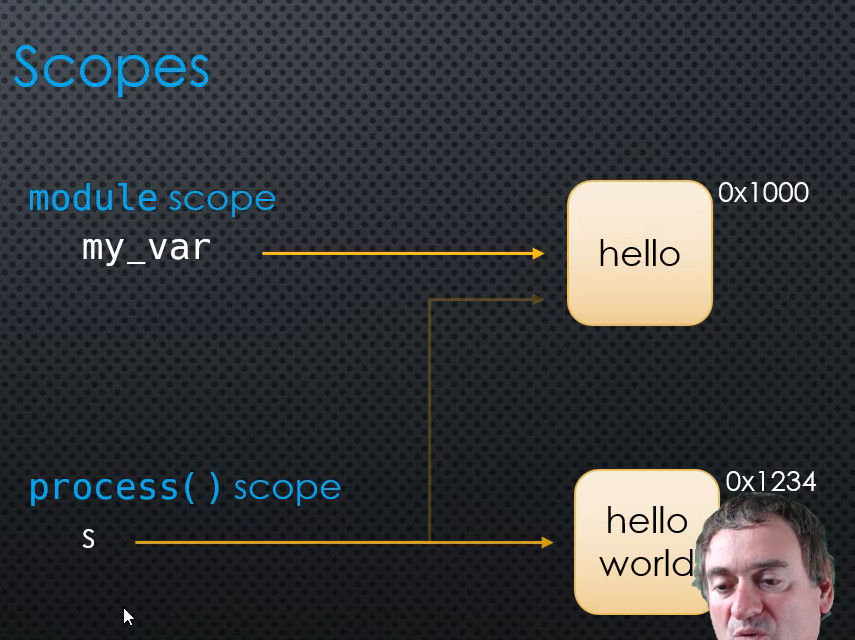

# 08 - Shared References and Mutability

One interesting thing to note is that if two variables have the same integer value, they will both point to the same memory reference, even though they were created independently. This is because integers are mutable objects and so we get a shared reference, done by Python Memory Manager.

In [57]:
a = 10
b = 10

print(hex(id(a)))
print(hex(id(b)))

0x7f5602434210
0x7f5602434210


But this isn't always the case; let's try a large number

In [62]:
a = 500
b = 500

print(hex(id(a)))
print(hex(id(b)))

0x7f55d79ee330
0x7f55d79ee7f0


We will see why in Section 09 - Variable Equality

With mutable objects like lists, we will never create a shared reference...

In [63]:
c = [1,2,3]
d = [1,2,3]

print(hex(id(a)))
print(hex(id(b)))   

0x7f55d79ee330
0x7f55d79ee7f0


...unless we point one variable to another.

In [64]:
e = [1,2,3]
f = e

print(hex(id(e)))
print(hex(id(f)))   

0x7f55d790da80
0x7f55d790da80
